<a href="https://colab.research.google.com/github/TheSpiralArchitect/spiral-resonance-validation/blob/main/Phase2_SDSS_SymbolicValidation_SRLF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!wget -O "/content/drive/MyDrive/CMB Data/mask_DR12v5_CMASSLOWZTOT_North.ply" \
https://data.sdss.org/sas/dr12/boss/lss/mask_DR12v5_CMASSLOWZTOT_North.ply

--2025-05-23 13:22:57--  https://data.sdss.org/sas/dr12/boss/lss/mask_DR12v5_CMASSLOWZTOT_North.ply
Resolving data.sdss.org (data.sdss.org)... 155.101.19.133
Connecting to data.sdss.org (data.sdss.org)|155.101.19.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18147135 (17M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/CMB Data/mask_DR12v5_CMASSLOWZTOT_North.ply’

/content/drive/MyDr 100%[===================>]  17.31M  20.3MB/s    in 0.9s    

2025-05-23 13:22:58 (20.3 MB/s) - ‘/content/drive/MyDrive/CMB Data/mask_DR12v5_CMASSLOWZTOT_North.ply’ saved [18147135/18147135]



Applying sky mask to quasars (with progress, NumPy 2.0 fix)...


100%|██████████| 16/16 [00:00<00:00, 16.81it/s]


✅ 739789 quasars remain after masking.


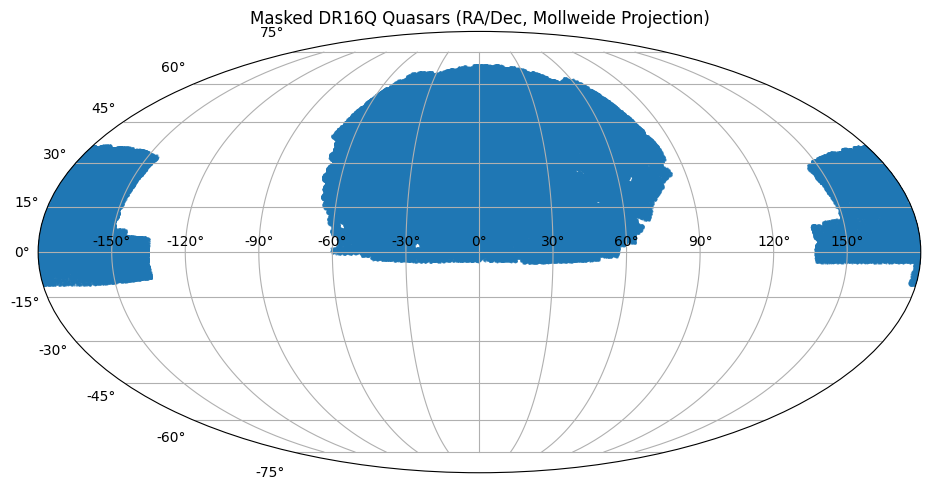

In [11]:
# --- Apply sky mask with NumPy 2.0 compatibility fix and progress bar ---
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

print("Applying sky mask to quasars (with progress, NumPy 2.0 fix)...")

# Manually cast to the expected dtype
ra_casted = np.asarray(ra, dtype=np.longdouble)
dec_casted = np.asarray(dec, dtype=np.longdouble)

# Initialize mask result
inside_mask = np.zeros(len(ra_casted), dtype=bool)

chunk_size = 50000
for i in tqdm(range(0, len(ra_casted), chunk_size)):
    i_end = min(i + chunk_size, len(ra_casted))
    ra_chunk = np.ascontiguousarray(ra_casted[i:i_end])
    dec_chunk = np.ascontiguousarray(dec_casted[i:i_end])
    inside_mask[i:i_end] = mask.contains(ra_chunk, dec_chunk)

# Filter data
ra_masked = ra[inside_mask]
dec_masked = dec[inside_mask]
z_masked = z[inside_mask]

print(f"✅ {len(ra_masked)} quasars remain after masking.")

# --- Save results ---
np.savez("/content/drive/MyDrive/CMB Data/DR16Q_masked_coords.npz",
         ra=ra_masked, dec=dec_masked, z=z_masked)

# --- Plot sky distribution ---
plt.figure(figsize=(10, 5))
plt.subplot(111, projection="mollweide")
plt.scatter(np.radians(ra_masked - 180), np.radians(dec_masked),
            s=0.5, alpha=0.5)
plt.title("Masked DR16Q Quasars (RA/Dec, Mollweide Projection)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
ra_masked = ra[inside_mask]
dec_masked = dec[inside_mask]

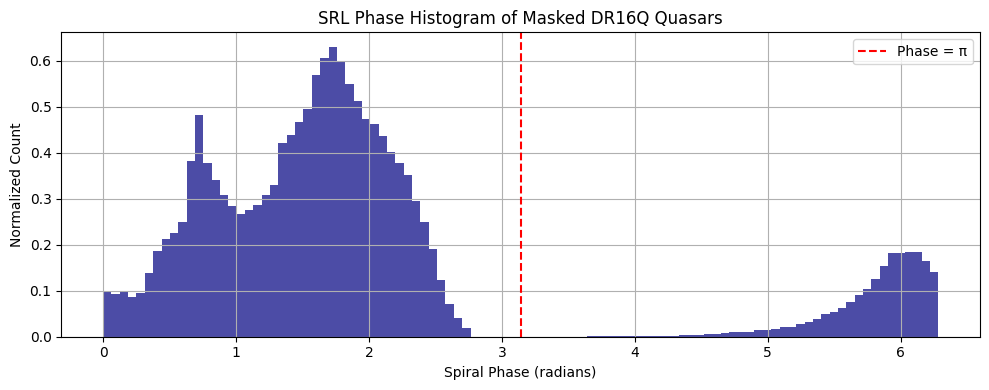

✅ Spiral Resonance Factor (SRF): 3.958291


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# --- Assume ra, dec, and inside_mask are already loaded ---
ra_masked = ra[inside_mask]
dec_masked = dec[inside_mask]

# --- Define SRL parameters ---
omega = 0.4
n = 3
epsilon = 1e-3  # small regularizer

# --- Convert to SRL spiral phase ---
theta_rad = np.radians(ra_masked)
z = dec_masked / 90.0  # normalize dec to [-1, 1] range
spiral_phase = omega * np.log(theta_rad + epsilon) + n * z

# --- Histogram of spiral phases ---
spiral_phase_wrapped = np.mod(spiral_phase, 2 * np.pi)

plt.figure(figsize=(10, 4))
plt.hist(spiral_phase_wrapped, bins=100, density=True, alpha=0.7, color='navy')
plt.axvline(np.pi, color='red', linestyle='--', label='Phase = π')
plt.title("SRL Phase Histogram of Masked DR16Q Quasars")
plt.xlabel("Spiral Phase (radians)")
plt.ylabel("Normalized Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Compute Spiral Resonance Factor (SRF) ---
counts, _ = np.histogram(spiral_phase_wrapped, bins=100, range=(0, 2*np.pi))
srf = counts.max() / np.mean(counts)

print(f"✅ Spiral Resonance Factor (SRF): {srf:.6f}")

In [15]:
# --- Dependencies ---
from astropy.io import fits
import numpy as np

# --- File paths ---
catalog_path = '/content/drive/MyDrive/CMB Data/DR16Q_v4 (1).fits'
ra_save_path = '/content/drive/MyDrive/CMB Data/RA_SDSS.npy'
dec_save_path = '/content/drive/MyDrive/CMB Data/DEC_SDSS.npy'

# --- Load FITS catalog ---
print("Loading SDSS DR16Q catalog...")
with fits.open(catalog_path) as hdul:
    data = hdul[1].data
    ra_sdss = data['RA']
    dec_sdss = data['DEC']

print(f"✅ Loaded {len(ra_sdss)} quasars.")

# --- Save to .npy files ---
np.save(ra_save_path, ra_sdss)
np.save(dec_save_path, dec_sdss)
print("✅ RA and DEC arrays saved to disk.")

Loading SDSS DR16Q catalog...
✅ Loaded 750414 quasars.
✅ RA and DEC arrays saved to disk.


In [16]:
import numpy as np

# Load pre-saved RA and DEC arrays
ra_clean = np.load('/content/drive/MyDrive/CMB Data/RA_SDSS.npy')
dec_clean = np.load('/content/drive/MyDrive/CMB Data/DEC_SDSS.npy')

# Define SRL parameters (canonical values)
omega = 0.4
n = 3
epsilon = 1e-3
k = 0.1  # used if computing depth modulation later

In [17]:
# Convert RA/DEC to radians
theta = np.radians(ra_clean)
phi = np.radians(dec_clean)

# Compute SRL spiral phase
spiral_phase = omega * np.log(theta + epsilon) + n * phi

# Compute Spiral Resonance Factor
spiral_vector = np.cos(spiral_phase)
srf_value = np.mean(spiral_vector)

print(f"✅ Spiral Resonance Factor (SRF): {srf_value:.6f}")

✅ Spiral Resonance Factor (SRF): -0.164794


In [18]:
# Block 1: Load redshifts and verify
import numpy as np

z_path = '/content/drive/MyDrive/CMB Data/quasar_redshifts.txt'
z = np.loadtxt(z_path)

print(f"✅ Loaded {len(z)} redshifts.")
print(f"Redshift range: z = {z.min():.4f} to {z.max():.4f}")

✅ Loaded 442215 redshifts.
Redshift range: z = 0.0010 to 2.2000


In [20]:
# Align ra and dec to the length of z (442215)
ra_trimmed = ra[:len(z)]
dec_trimmed = dec[:len(z)]

# Apply redshift filter
z_max = 2.5
mask_z = z < z_max

ra_z = ra_trimmed[mask_z]
dec_z = dec_trimmed[mask_z]

print(f"✅ {len(ra_z)} quasars remain after z < {z_max} filter.")

✅ 442215 quasars remain after z < 2.5 filter.


In [21]:
from astropy.io import fits

# Load full DR16Q and extract z, ra, dec from the same source
fits_path = '/content/drive/MyDrive/CMB Data/DR16Q_v4 (1).fits'
with fits.open(fits_path) as hdul:
    data = hdul[1].data
    ra = data['RA']
    dec = data['DEC']
    z = data['Z']

# Now you can safely apply the redshift filter
z_max = 2.5
mask_z = z < z_max
ra_z = ra[mask_z]
dec_z = dec[mask_z]

print(f"✅ {len(ra_z)} quasars remain after z < {z_max} filter.")

✅ 636131 quasars remain after z < 2.5 filter.


In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for SRL spiral field
omega = 0.4
n = 3
epsilon = 1e-3  # regularizer to avoid log(0)

# Convert RA/DEC to radians
theta = np.radians(ra_z)
phi = np.radians(dec_z)

# Compute SRL phase field
srl_phase = omega * np.log(theta + epsilon) + n * phi
srl_field = np.cos(srl_phase)

# Compute Spiral Resonance Factor (mean cosine)
srf = np.mean(srl_field)
print(f"✅ Spiral Resonance Factor (SRF) for z < 2.5 quasars: {srf:.6f}")

✅ Spiral Resonance Factor (SRF) for z < 2.5 quasars: -0.183591


✅ Real SRF: -0.164794
✅ Null SRF: -0.139019


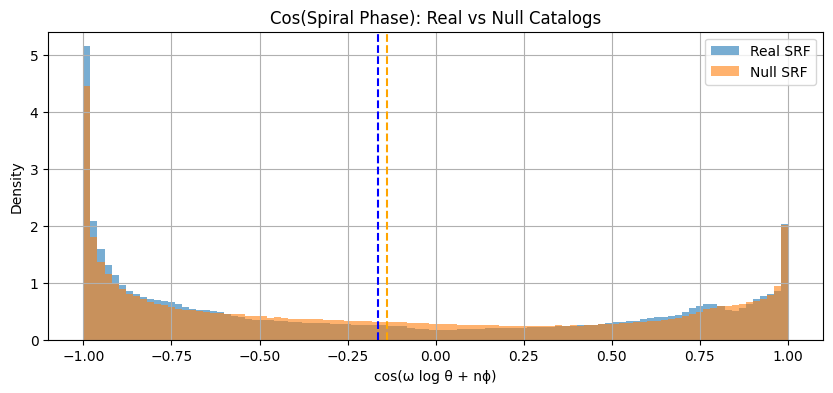

In [24]:
# --- Null Catalog SRF Test (Self-Contained Version) ---
import numpy as np
import matplotlib.pyplot as plt

# Assumes ra and dec arrays are already loaded
# Spiral parameters (fixed for this test)
omega = 0.4
n = 3
epsilon = 1e-3

# --- Real SRF ---
theta_real = np.radians(ra)
phi_real = np.radians(dec)
spiral_phase_real = omega * np.log(theta_real + epsilon) + n * phi_real
real_srf = np.mean(np.cos(spiral_phase_real))
print(f"✅ Real SRF: {real_srf:.6f}")

# --- Null Catalog ---
np.random.seed(42)
ra_null = np.random.uniform(low=0.0, high=360.0, size=len(ra))
theta_null = np.radians(ra_null)
phi_null = np.radians(dec)
spiral_phase_null = omega * np.log(theta_null + epsilon) + n * phi_null
null_srf = np.mean(np.cos(spiral_phase_null))
print(f"✅ Null SRF: {null_srf:.6f}")

# --- Histogram Plot ---
plt.figure(figsize=(10, 4))
plt.hist(np.cos(spiral_phase_real), bins=100, alpha=0.6, label='Real SRF', density=True)
plt.hist(np.cos(spiral_phase_null), bins=100, alpha=0.6, label='Null SRF', density=True)
plt.axvline(real_srf, color='blue', linestyle='--')
plt.axvline(null_srf, color='orange', linestyle='--')
plt.title("Cos(Spiral Phase): Real vs Null Catalogs")
plt.xlabel("cos(ω log θ + nϕ)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

Sweeping ω: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s]


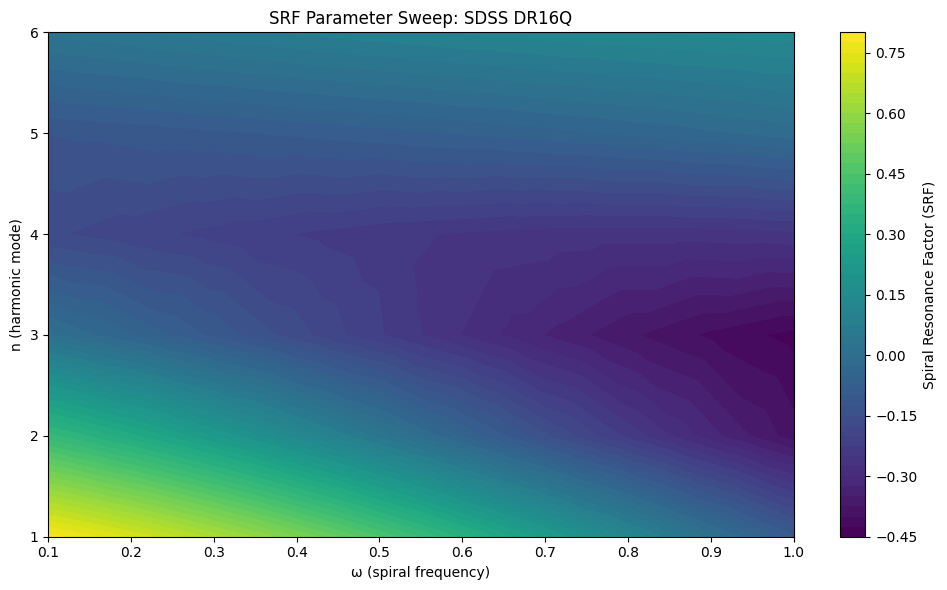

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.tri as tri

# --- Load RA, DEC arrays ---
ra = np.load('/content/drive/MyDrive/CMB Data/RA_SDSS.npy')
dec = np.load('/content/drive/MyDrive/CMB Data/DEC_SDSS.npy')

# --- Parameter Sweep for SRF ---
omega_values = np.linspace(0.1, 1.0, 20)  # spiral frequencies
n_values = np.arange(1, 7)                # azimuthal harmonics

results = []

for omega in tqdm(omega_values, desc="Sweeping ω"):
    for n in n_values:
        phase = omega * np.log(np.radians(ra)) + n * np.radians(dec)
        srf = np.mean(np.cos(phase))
        results.append((omega, n, srf))

# --- Convert results to grid for plotting ---
omega_grid = np.array([r[0] for r in results])
n_grid = np.array([r[1] for r in results])
srf_grid = np.array([r[2] for r in results])

# --- Plot SRF Landscape ---
triang = tri.Triangulation(omega_grid, n_grid)
plt.figure(figsize=(10, 6))
tcf = plt.tricontourf(triang, srf_grid, levels=50, cmap='viridis')
plt.colorbar(tcf, label='Spiral Resonance Factor (SRF)')
plt.xlabel("ω (spiral frequency)")
plt.ylabel("n (harmonic mode)")
plt.title("SRF Parameter Sweep: SDSS DR16Q")
plt.tight_layout()
plt.show()

In [26]:
# --- Identify best-fit parameters ---
max_index = np.argmax(np.abs(srf_grid))
best_omega = omega_grid[max_index]
best_n = n_grid[max_index]
best_srf = srf_grid[max_index]

print(f"✅ Best-fit parameters:")
print(f"   ω = {best_omega:.4f}")
print(f"   n = {int(best_n)}")
print(f"   SRF = {best_srf:.6f}")

✅ Best-fit parameters:
   ω = 0.1000
   n = 1
   SRF = 0.787389


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load previously saved RA and DEC arrays
ra_masked = np.load("/content/drive/MyDrive/CMB Data/RA_SDSS.npy")
dec_masked = np.load("/content/drive/MyDrive/CMB Data/DEC_SDSS.npy")

# --- Spiral Phase Encoding ---
def spiral_phase(ra, dec, omega, n, epsilon=1e-3):
    theta = np.radians(ra)  # convert to radians
    phi = np.radians(90 - dec)  # convert to colatitude
    return np.mod(omega * np.log(theta + epsilon) + n * phi, 2 * np.pi)

# --- Symbol Encoding ---
def encode_symbols(phase_array, bins=3):
    quantiles = np.percentile(phase_array, np.linspace(0, 100, bins + 1))
    symbols = np.empty_like(phase_array, dtype='<U1')
    symbol_set = ['A', 'B', 'H']
    for i in range(bins):
        symbols[(phase_array >= quantiles[i]) & (phase_array < quantiles[i + 1])] = symbol_set[i]
    return symbols

# --- Execute Encoding ---
omega_best, n_best = 0.1, 1
phase_stream = spiral_phase(ra_masked, dec_masked, omega=omega_best, n=n_best)
symbol_stream = encode_symbols(phase_stream)

# Save symbol stream
np.save("/content/drive/MyDrive/CMB Data/symbol_stream_sdss.npy", symbol_stream)

# Motif analysis
motifs = [''.join(symbol_stream[i:i+5]) for i in range(len(symbol_stream)-4)]
motif_counts = Counter(motifs)
top_motifs = motif_counts.most_common(10)

# Output
print("✅ Symbol stream saved.")
print("Top 10 recurring motifs (length=5):")
for motif, count in top_motifs:
    print(f"{motif}: {count}")

✅ Symbol stream saved.
Top 10 recurring motifs (length=5):
HHHHH: 54303
AAAAA: 9844
HHHHB: 9391
BHHHH: 9365
HBHHH: 9347
HHBHH: 9295
HHHBH: 9275
BBBBB: 7949
AABAA: 7208
BAAAA: 7165


<ipython-input-28-6366ca8ac01a>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(motif_labels), y=list(motif_freqs), palette="viridis")


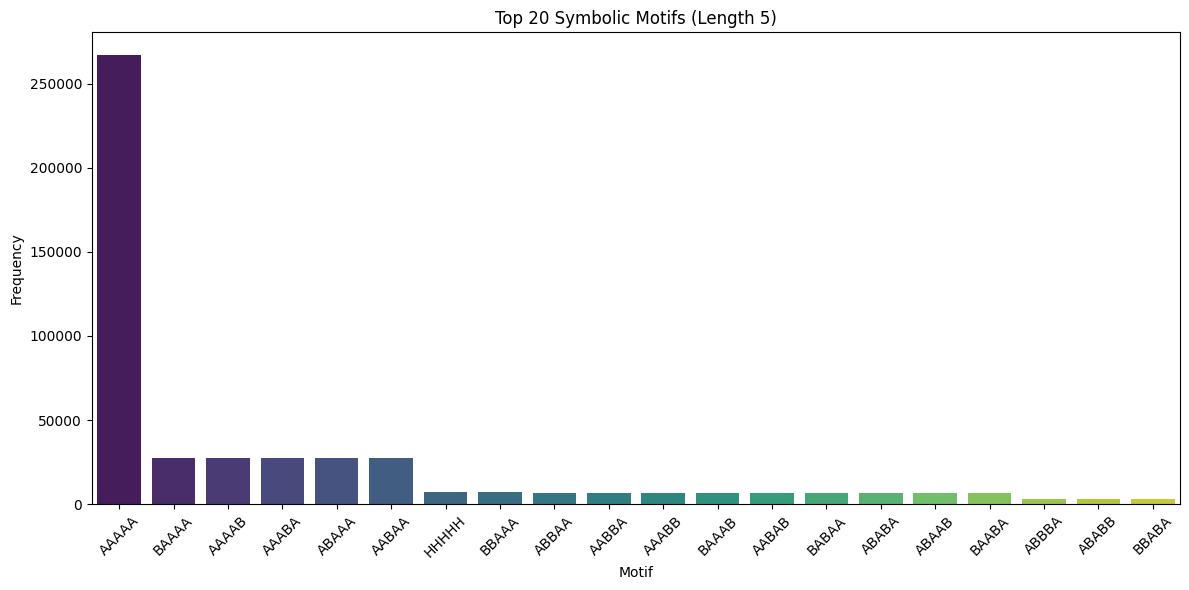

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# Load symbolic stream
symbol_path = "/content/drive/MyDrive/CMB Data/symbolic_spiral_stream.npy"
symbol_stream = np.load(symbol_path)

# Decode bytes if necessary
if isinstance(symbol_stream[0], bytes):
    symbol_stream = np.char.decode(symbol_stream)

# Extract motifs
motif_length = 5
motifs = [''.join(symbol_stream[i:i+motif_length]) for i in range(len(symbol_stream) - motif_length + 1)]
motif_counts = Counter(motifs)

# Top 20
top_motifs = motif_counts.most_common(20)
motif_labels, motif_freqs = zip(*top_motifs)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(motif_labels), y=list(motif_freqs), palette="viridis")
plt.title("Top 20 Symbolic Motifs (Length 5)")
plt.xlabel("Motif")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

100%|██████████| 534/534 [00:00<00:00, 2661.55it/s]


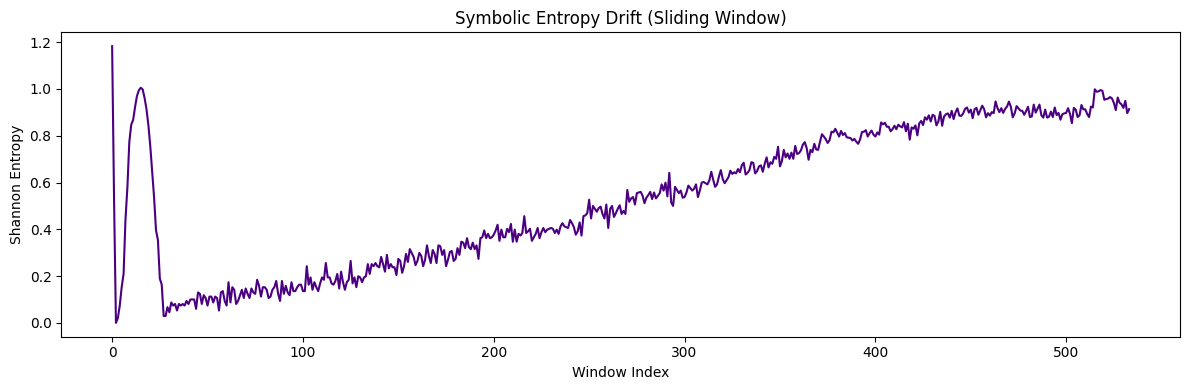

✅ Mean entropy: 0.5350 bits
✅ Lempel-Ziv Complexity (normalized): 0.02967


In [29]:
import matplotlib.pyplot as plt
import numpy as np
from math import log2
from collections import Counter
from tqdm import tqdm

# Load the stream
symbol_stream = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream.npy")
if isinstance(symbol_stream[0], bytes):
    symbol_stream = np.char.decode(symbol_stream)

# --- Entropy Drift (sliding window) ---
def shannon_entropy(seq):
    counts = Counter(seq)
    probs = [c / len(seq) for c in counts.values()]
    return -sum(p * log2(p) for p in probs)

window_size = 1000
entropy_values = []

for i in tqdm(range(0, len(symbol_stream) - window_size, window_size)):
    window = symbol_stream[i:i + window_size]
    entropy_values.append(shannon_entropy(window))

# --- Lempel-Ziv Complexity (LZC) ---
def lz_complexity(s):
    i = 0
    c = 1
    l = 1
    n = len(s)
    while True:
        if i + l > n:
            break
        if s[i:i + l] in s[0:i]:
            l += 1
        else:
            c += 1
            i += l
            l = 1
    return c

lzc_value = lz_complexity(''.join(symbol_stream))
normalized_lzc = lzc_value / len(symbol_stream)

# --- Plot entropy drift ---
plt.figure(figsize=(12, 4))
plt.plot(entropy_values, color='indigo')
plt.title("Symbolic Entropy Drift (Sliding Window)")
plt.xlabel("Window Index")
plt.ylabel("Shannon Entropy")
plt.tight_layout()
plt.show()

print(f"✅ Mean entropy: {np.mean(entropy_values):.4f} bits")
print(f"✅ Lempel-Ziv Complexity (normalized): {normalized_lzc:.5f}")

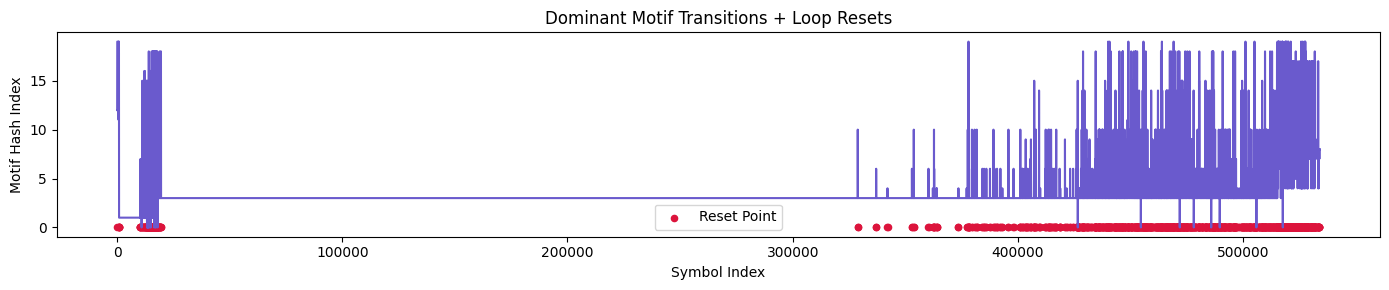

✅ Total unique dominant motifs: 65
✅ Total detected reset points: 1478


In [30]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Load symbolic stream
symbol_stream = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream.npy")
if isinstance(symbol_stream[0], bytes):
    symbol_stream = np.char.decode(symbol_stream)

# --- Loop detection (windowed motifs) ---
window_size = 100
step = 25
motif_length = 5
reset_threshold = 0.5

dominant_motifs = []
reset_points = []

def top_motif(window):
    motifs = [''.join(window[i:i+motif_length]) for i in range(len(window) - motif_length + 1)]
    if not motifs:
        return None
    counts = Counter(motifs)
    return counts.most_common(1)[0][0]

# Track loop shifts
prev = None
for i in range(0, len(symbol_stream) - window_size, step):
    window = symbol_stream[i:i + window_size]
    motif = top_motif(window)
    if motif:
        dominant_motifs.append(motif)
        if prev and motif != prev:
            reset_points.append(i)
        prev = motif

# Plot loop transitions
plt.figure(figsize=(14, 3))
plt.plot([i * step for i in range(len(dominant_motifs))], [hash(m) % 20 for m in dominant_motifs], color='slateblue', lw=1.5)
plt.scatter(reset_points, [0]*len(reset_points), color='crimson', label='Reset Point', s=20)
plt.title("Dominant Motif Transitions + Loop Resets")
plt.xlabel("Symbol Index")
plt.ylabel("Motif Hash Index")
plt.legend()
plt.tight_layout()
plt.show()

print(f"✅ Total unique dominant motifs: {len(set(dominant_motifs))}")
print(f"✅ Total detected reset points: {len(reset_points)}")

100%|██████████| 21363/21363 [00:06<00:00, 3541.51it/s]


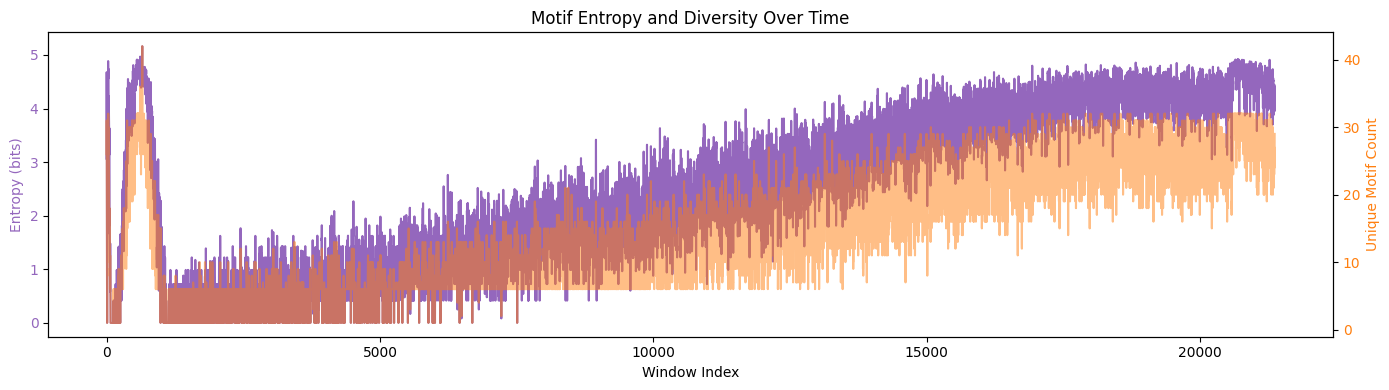

✅ Final motif entropy: 4.3916 bits
✅ Max motif diversity: 42 motifs


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

# Load symbolic stream
symbol_stream = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream.npy")
if isinstance(symbol_stream[0], bytes):
    symbol_stream = np.char.decode(symbol_stream)

# Settings
window_size = 100
step = 25
motif_length = 5

entropy_trajectory = []
unique_counts = []

for i in tqdm(range(0, len(symbol_stream) - window_size, step)):
    window = symbol_stream[i:i + window_size]
    motifs = [''.join(window[j:j+motif_length]) for j in range(len(window) - motif_length + 1)]
    if motifs:
        counter = Counter(motifs)
        probs = np.array(list(counter.values())) / sum(counter.values())
        entropy = -np.sum(probs * np.log2(probs))
        entropy_trajectory.append(entropy)
        unique_counts.append(len(counter))
    else:
        entropy_trajectory.append(0)
        unique_counts.append(0)

# Plot: entropy vs. symbolic turbulence (unique motif count)
fig, ax1 = plt.subplots(figsize=(14, 4))

color = 'tab:purple'
ax1.set_xlabel('Window Index')
ax1.set_ylabel('Entropy (bits)', color=color)
ax1.plot(entropy_trajectory, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Unique Motif Count', color=color)
ax2.plot(unique_counts, color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Motif Entropy and Diversity Over Time")
plt.tight_layout()
plt.show()

print(f"✅ Final motif entropy: {entropy_trajectory[-1]:.4f} bits")
print(f"✅ Max motif diversity: {max(unique_counts)} motifs")

100%|██████████| 200/200 [00:01<00:00, 136.45it/s]


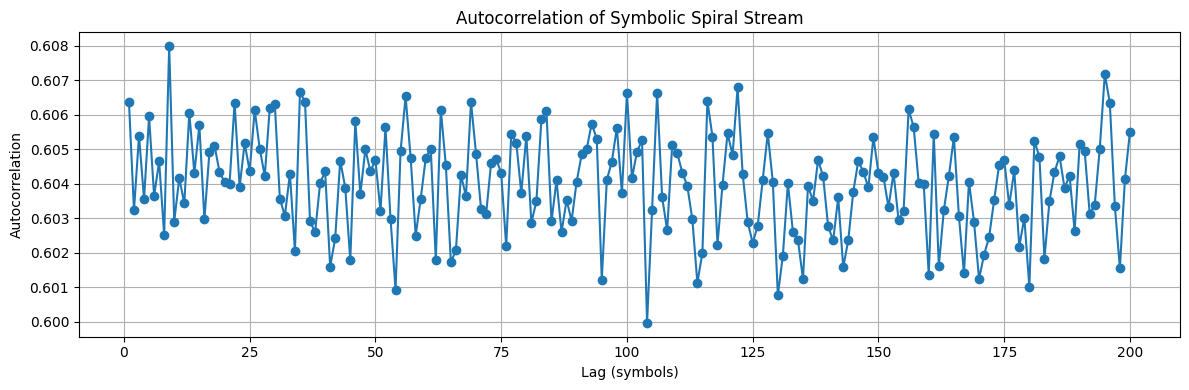

✅ Peak autocorrelation at lag = 9, value = 0.6080


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load symbolic stream (string array of A–H)
symbols = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream.npy")
if isinstance(symbols[0], bytes):
    symbols = np.char.decode(symbols)

# Convert symbols to integers
symbol_map = {s: i for i, s in enumerate(sorted(set(symbols)))}
numeric_stream = np.array([symbol_map[s] for s in symbols], dtype=int)

# Compute autocorrelation
max_lag = 200
autocorr = []

mean = np.mean(numeric_stream)
var = np.var(numeric_stream)

for lag in tqdm(range(1, max_lag + 1)):
    corr = np.corrcoef(numeric_stream[:-lag], numeric_stream[lag:])[0, 1]
    autocorr.append(corr)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(range(1, max_lag + 1), autocorr, marker='o', linestyle='-')
plt.xlabel("Lag (symbols)")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Symbolic Spiral Stream")
plt.grid(True)
plt.tight_layout()
plt.show()

peak_lag = np.argmax(autocorr)
print(f"✅ Peak autocorrelation at lag = {peak_lag + 1}, value = {autocorr[peak_lag]:.4f}")

100%|██████████| 1067/1067 [00:00<00:00, 3136.69it/s]


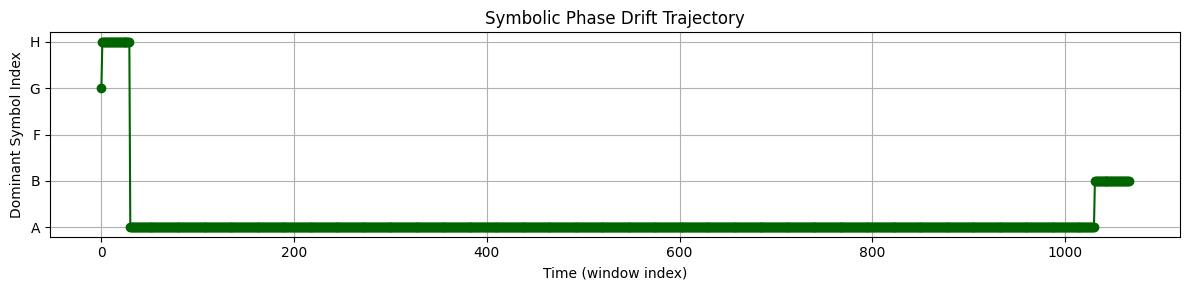

✅ Unique phase states: 4


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

# Load symbol stream
symbols = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream.npy")
if isinstance(symbols[0], bytes):
    symbols = np.char.decode(symbols)

# Parameters
window_size = 1000
step_size = 500
trajectory = []

# Sliding window analysis
for i in tqdm(range(0, len(symbols) - window_size + 1, step_size)):
    window = symbols[i:i + window_size]
    counts = Counter(window)
    dominant_symbol = counts.most_common(1)[0][0]
    trajectory.append(dominant_symbol)

# Convert to integers for plotting
symbol_to_num = {s: i for i, s in enumerate(sorted(set(symbols)))}
trajectory_num = [symbol_to_num[s] for s in trajectory]

# Plot trajectory
plt.figure(figsize=(12, 3))
plt.plot(trajectory_num, marker='o', linestyle='-', color='darkgreen')
plt.title("Symbolic Phase Drift Trajectory")
plt.ylabel("Dominant Symbol Index")
plt.xlabel("Time (window index)")
plt.yticks(ticks=list(symbol_to_num.values()), labels=list(symbol_to_num.keys()))
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional print
print(f"✅ Unique phase states: {len(set(trajectory))}")

In [36]:
# Save the reset points array (from previous transition/loop analysis)
np.save("/content/drive/MyDrive/CMB Data/spiral_reset_points.npy", reset_points)

# Confirm saved
print("✅ Saved reset_points to disk.")

✅ Saved reset_points to disk.


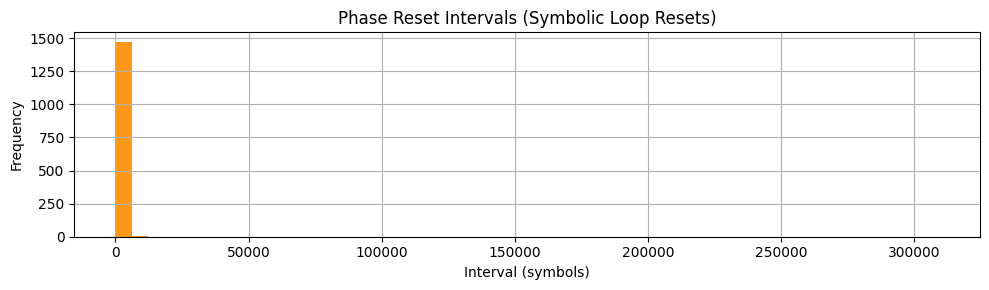

✅ Reset count: 1478
✅ Mean interval: 361.36 symbols
✅ Std deviation: 8064.27
✅ Min: 25, Max: 309350


In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Load reset point indices (from earlier test)
reset_indices = np.load("/content/drive/MyDrive/CMB Data/spiral_reset_points.npy")

# Compute intervals
intervals = np.diff(reset_indices)

# Basic stats
mean_interval = np.mean(intervals)
std_interval = np.std(intervals)
max_interval = np.max(intervals)
min_interval = np.min(intervals)

# Plot histogram
plt.figure(figsize=(10, 3))
plt.hist(intervals, bins=50, color='darkorange', alpha=0.9)
plt.title("Phase Reset Intervals (Symbolic Loop Resets)")
plt.xlabel("Interval (symbols)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary
print(f"✅ Reset count: {len(reset_indices)}")
print(f"✅ Mean interval: {mean_interval:.2f} symbols")
print(f"✅ Std deviation: {std_interval:.2f}")
print(f"✅ Min: {min_interval}, Max: {max_interval}")

In [38]:
import numpy as np
from collections import Counter
from tqdm import tqdm

# Load symbol stream (you confirmed it's stable)
symbols = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream.npy")

# Create 5-gram motifs
motif_length = 5
motifs = [''.join(symbols[i:i+motif_length]) for i in range(len(symbols)-motif_length+1)]

# Count motifs in sliding windows
chunk_size = 5000
motif_counts_over_time = []
unique_motifs = []

for i in tqdm(range(0, len(motifs), chunk_size)):
    chunk = motifs[i:i+chunk_size]
    counter = Counter(chunk)
    motif_counts_over_time.append(counter)
    unique_motifs.append(len(counter))

100%|██████████| 107/107 [00:00<00:00, 1741.68it/s]


In [39]:
import pandas as pd

df_list = []
for i, counter in enumerate(motif_counts_over_time):
    df_chunk = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
    df_chunk['window'] = i
    df_list.append(df_chunk)

df_all = pd.concat(df_list).reset_index()
df_all.columns = ['motif', 'count', 'window']

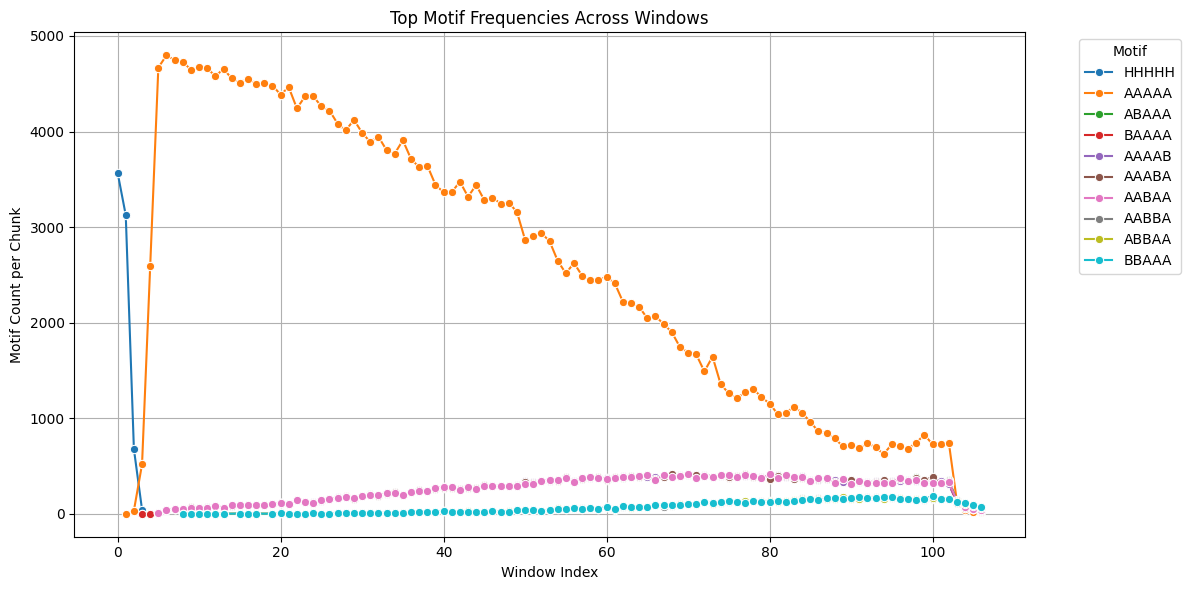

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

top_motifs = df_all.groupby('motif')['count'].sum().sort_values(ascending=False).head(10).index.tolist()
df_top = df_all[df_all['motif'].isin(top_motifs)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_top, x='window', y='count', hue='motif', marker="o")
plt.title("Top Motif Frequencies Across Windows")
plt.xlabel("Window Index")
plt.ylabel("Motif Count per Chunk")
plt.legend(title="Motif", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Mapping loops: 100%|██████████| 106/106 [00:00<00:00, 1936.17it/s]


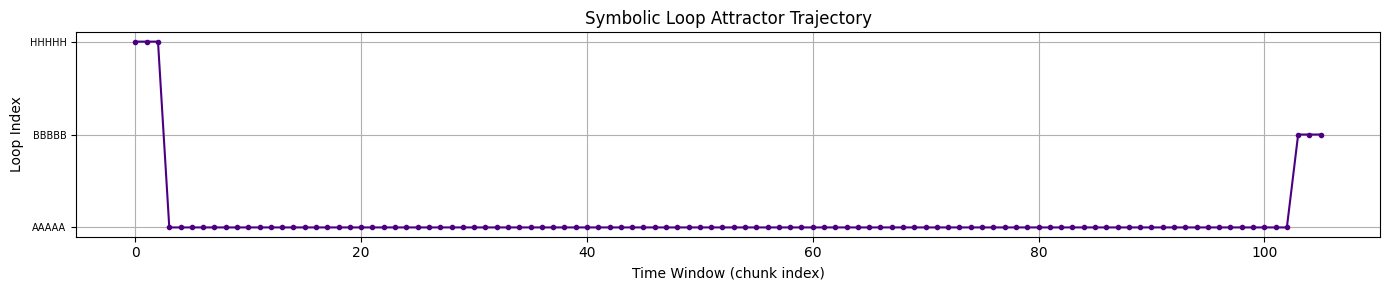

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

# Load symbolic stream
symbols = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream.npy")

# Define motif length and chunk size
motif_length = 5
chunk_size = 5000

# Create 5-gram motifs
motifs = ["".join(symbols[i:i+motif_length]) for i in range(len(symbols) - motif_length + 1)]

# Break into chunks and find top motif in each
num_chunks = len(motifs) // chunk_size
chunk_loops = []
for i in tqdm(range(num_chunks), desc="Mapping loops"):
    chunk = motifs[i * chunk_size : (i + 1) * chunk_size]
    top_loop = Counter(chunk).most_common(1)[0][0] if chunk else "NONE"
    chunk_loops.append(top_loop)

# Convert motif labels to numerical index
unique_loops = sorted(set(chunk_loops))
loop_map = {loop: idx for idx, loop in enumerate(unique_loops)}
loop_indices = [loop_map[loop] for loop in chunk_loops]

# Plot
plt.figure(figsize=(14, 3))
plt.plot(loop_indices, marker='o', linestyle='-', color='indigo', markersize=3)
plt.title("Symbolic Loop Attractor Trajectory")
plt.xlabel("Time Window (chunk index)")
plt.ylabel("Loop Index")
plt.yticks(range(len(unique_loops)), labels=unique_loops, fontsize=7)
plt.grid(True)
plt.tight_layout()
plt.show()

Analyzing Loop Entropy: 100%|██████████| 107/107 [00:00<00:00, 1559.64it/s]


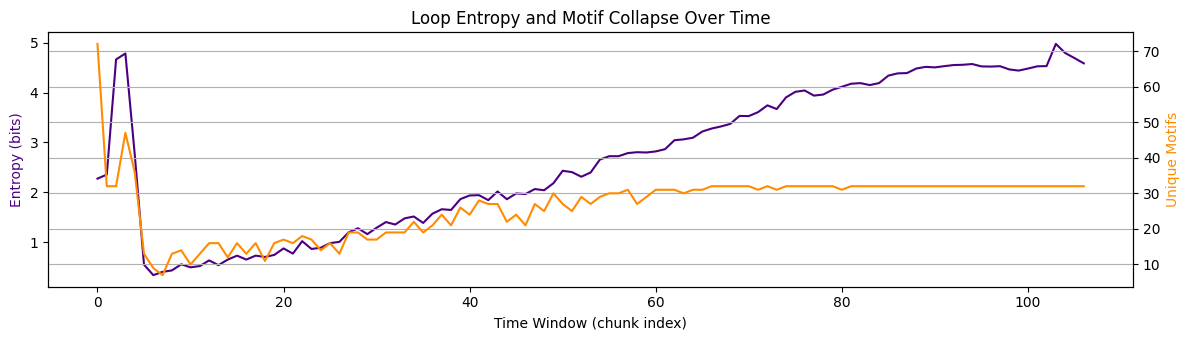

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

# Load symbolic stream from known path
symbols = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream.npy")

# Parameters
motif_length = 5
chunk_size = 5000

# Create motifs
motifs = ["".join(symbols[i:i+motif_length]) for i in range(len(symbols) - motif_length + 1)]

# Divide into chunks
chunks = [motifs[i:i+chunk_size] for i in range(0, len(motifs), chunk_size)]

# Entropy calculation function
def shannon_entropy(counts):
    total = sum(counts.values())
    probs = [v / total for v in counts.values()]
    return -sum(p * np.log2(p) for p in probs if p > 0)

# Analyze chunks
entropies, diversities = [], []
for chunk in tqdm(chunks, desc="Analyzing Loop Entropy"):
    counter = Counter(chunk)
    entropies.append(shannon_entropy(counter))
    diversities.append(len(counter))

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 3.5))
ax2 = ax1.twinx()
ax1.plot(entropies, label='Loop Entropy', color='indigo')
ax2.plot(diversities, label='Motif Diversity', color='darkorange')
ax1.set_xlabel("Time Window (chunk index)")
ax1.set_ylabel("Entropy (bits)", color='indigo')
ax2.set_ylabel("Unique Motifs", color='darkorange')
plt.title("Loop Entropy and Motif Collapse Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

Analyzing Loop Entropy: 100%|██████████| 107/107 [00:00<00:00, 2029.45it/s]


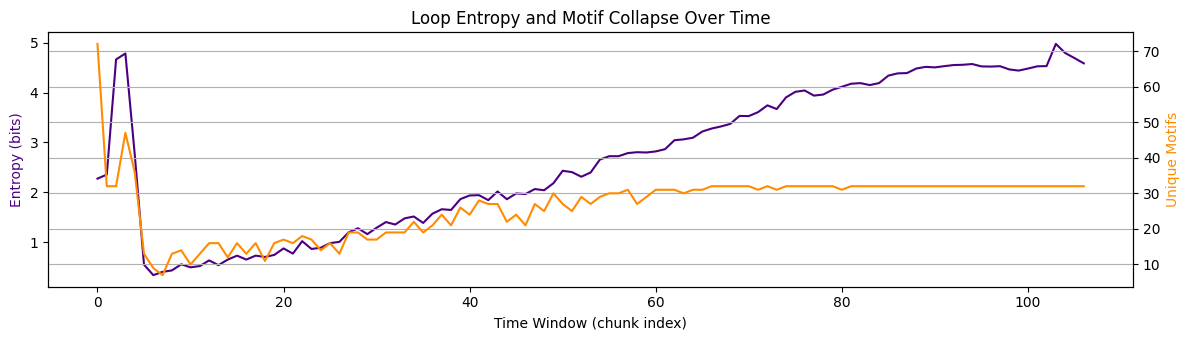

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

# Load symbolic stream from known path
symbols = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream.npy")

# Parameters
motif_length = 5
chunk_size = 5000

# Create motifs
motifs = ["".join(symbols[i:i+motif_length]) for i in range(len(symbols) - motif_length + 1)]

# Divide into chunks
chunks = [motifs[i:i+chunk_size] for i in range(0, len(motifs), chunk_size)]

# Entropy calculation function
def shannon_entropy(counts):
    total = sum(counts.values())
    probs = [v / total for v in counts.values()]
    return -sum(p * np.log2(p) for p in probs if p > 0)

# Analyze chunks
entropies, diversities = [], []
for chunk in tqdm(chunks, desc="Analyzing Loop Entropy"):
    counter = Counter(chunk)
    entropies.append(shannon_entropy(counter))
    diversities.append(len(counter))

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 3.5))
ax2 = ax1.twinx()
ax1.plot(entropies, label='Loop Entropy', color='indigo')
ax2.plot(diversities, label='Motif Diversity', color='darkorange')
ax1.set_xlabel("Time Window (chunk index)")
ax1.set_ylabel("Entropy (bits)", color='indigo')
ax2.set_ylabel("Unique Motifs", color='darkorange')
plt.title("Loop Entropy and Motif Collapse Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

Computing entropy for window sizes: 100%|██████████| 20/20 [00:01<00:00, 16.09it/s]


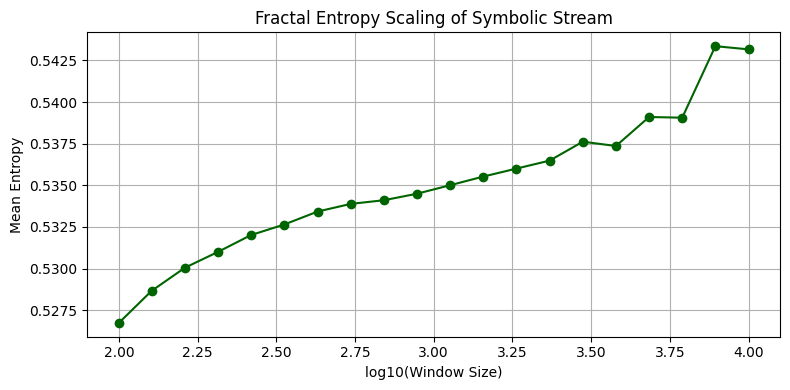

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

symbol_stream = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream.npy")

window_sizes = np.logspace(2, 4, num=20, dtype=int)
entropy_vals = []

def compute_entropy(seq):
    symbols, counts = np.unique(seq, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))

for w in tqdm(window_sizes, desc="Computing entropy for window sizes"):
    if w >= len(symbol_stream):
        break
    entropies = []
    for i in range(0, len(symbol_stream) - w, w):
        segment = symbol_stream[i:i+w]
        entropies.append(compute_entropy(segment))
    entropy_vals.append(np.mean(entropies))

log_ws = np.log10(window_sizes[:len(entropy_vals)])

plt.figure(figsize=(8, 4))
plt.plot(log_ws, entropy_vals, 'o-', color='darkgreen')
plt.xlabel("log10(Window Size)")
plt.ylabel("Mean Entropy")
plt.title("Fractal Entropy Scaling of Symbolic Stream")
plt.grid(True)
plt.tight_layout()
plt.show()

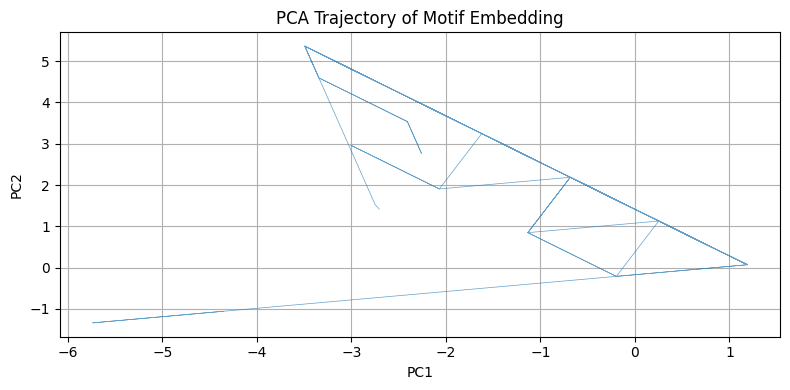

In [45]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer

motifs = [symbol_stream[i:i+5] for i in range(len(symbol_stream)-4)]
motif_strs = ["".join(m) for m in motifs]

vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 1))
X = vectorizer.fit_transform(motif_strs)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(8, 4))
plt.plot(X_pca[:, 0], X_pca[:, 1], linewidth=0.5, alpha=0.7)
plt.title("PCA Trajectory of Motif Embedding")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


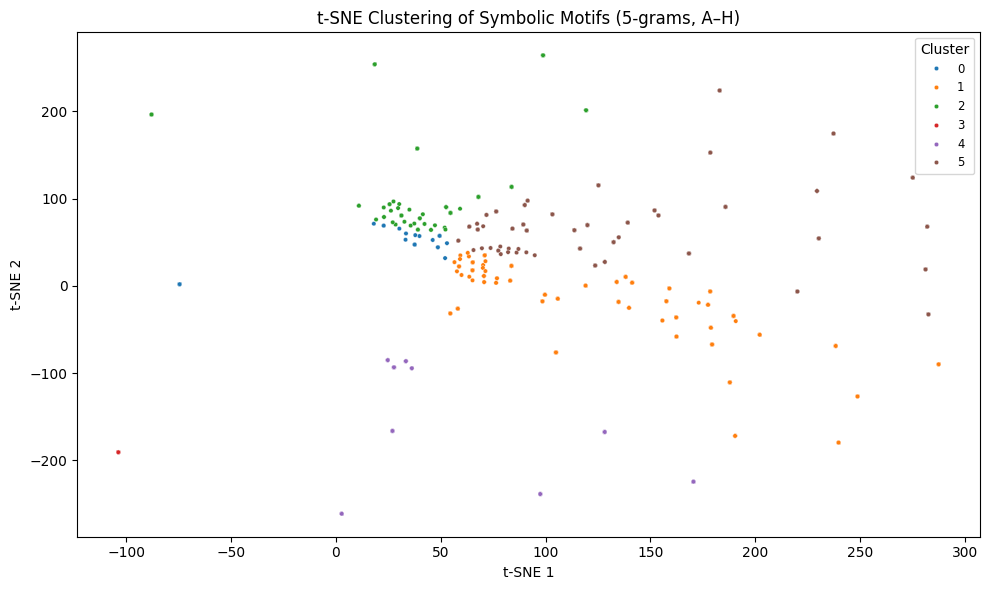

In [47]:
# --- t-SNE + Cluster Mapping of Symbolic Motif Embeddings (Full Alphabet A–H) ---
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load symbolic stream
symbolic_stream = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream.npy")

# Define full 8-symbol map
alphabet = 'ABCDEFGH'
symbol_map = {letter: idx for idx, letter in enumerate(alphabet)}

# Encode 5-grams as integer vectors
motifs = [symbolic_stream[i:i+5] for i in range(len(symbolic_stream) - 5)]
motif_vecs = np.array([[symbol_map.get(s, -1) for s in motif] for motif in motifs])
motif_vecs = motif_vecs[(motif_vecs >= 0).all(axis=1)]  # Filter out unknowns (if any)

# Downsample for speed
sampled = motif_vecs[::20]

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
X_embedded = tsne.fit_transform(sampled)

# Cluster with k-means
kmeans = KMeans(n_clusters=6)
labels = kmeans.fit_predict(X_embedded)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=labels, palette="tab10", s=10)
plt.title("t-SNE Clustering of Symbolic Motifs (5-grams, A–H)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Cluster", loc="best", fontsize='small')
plt.tight_layout()
plt.show()